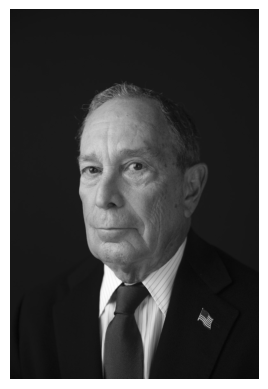

In [71]:
from PIL import Image

# Open the image file
img = Image.open('bloomberg.jpg')

# Convert the image to grayscale
gray_img = img.convert('L')

# Save the grayscale image
gray_img.save('bloomberg_gray.jpg')

# Display the grayscale image
import matplotlib.pyplot as plt

# Display the grayscale image in the notebook
plt.imshow(gray_img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

torch.Size([1, 1160, 780])
torch.Size([1160, 780])


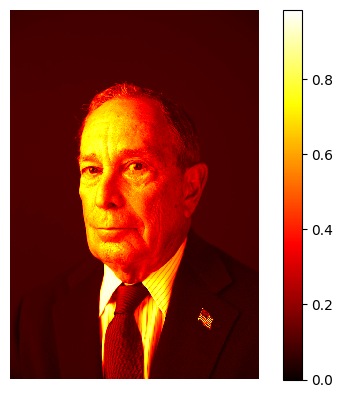

In [72]:
import torch

import torchvision.transforms as transforms

# Define a transform to convert the image to a tensor
transform = transforms.ToTensor()

# Apply the transform to the grayscale image
tensor_img = transform(gray_img)

# Print the shape of the tensor
print(tensor_img.shape)

# Squeeze the tensor to remove the single-dimensional entries
squeezed_tensor_img = torch.squeeze(tensor_img, 0)

# Print the shape of the squeezed tensor
print(squeezed_tensor_img.shape)

plt.imshow(squeezed_tensor_img.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.axis('off')  # Hide the axis
plt.show()

In [73]:
# test_height = 0.5

# squeezed_tensor_img_clone = squeezed_tensor_img.clone()
# squeezed_tensor_img_clone[squeezed_tensor_img_clone > test_height] = 1.0

# plt.imshow(squeezed_tensor_img_clone.numpy(), cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.axis('off')  # Hide the axis
# plt.show()

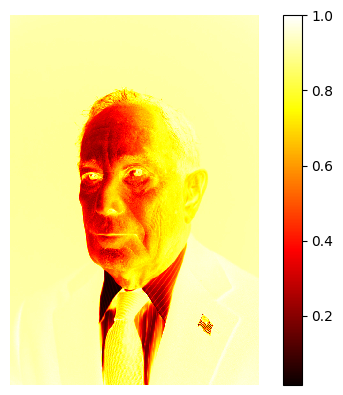

In [74]:
# Invert the image

squeezed_tensor_img_clone = 1 - squeezed_tensor_img
squeezed_tensor_img = squeezed_tensor_img_clone

plt.imshow(squeezed_tensor_img_clone.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.axis('off')  # Hide the axis
plt.show()

Ball position: (400, 400)


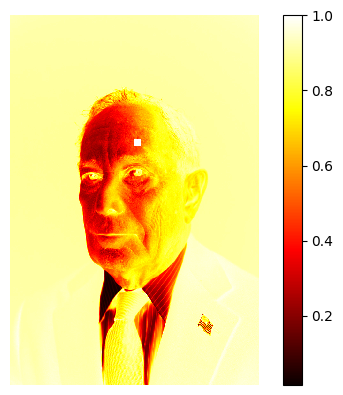

In [75]:
# mark (for display where the ball would be)
import random
marked_img = squeezed_tensor_img.clone()

# Define a ball that moves
height, width = squeezed_tensor_img.shape


# Define a point within the bounds of the squeezed tensor image
ball_position = (400, 400)
print(f"Ball position: {ball_position}")

# Mark the ball position on the squeezed tensor image
marked_img[ball_position] = 1.0  # Mark the ball position with the maximum value

# Define the range around the ball position to be marked
range_size = 10

# Mark the range around the ball position
for i in range(max(0, ball_position[0] - range_size), min(height, ball_position[0] + range_size + 1)):
    for j in range(max(0, ball_position[1] - range_size), min(width, ball_position[1] + range_size + 1)):
        marked_img[i, j] = 1.0  # Mark the range with the maximum value

# Display the image with the marked ball position
plt.imshow(marked_img.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.axis('off')  # Hide the axis
plt.show()

In [76]:
# # Give this ball some random velocity so that the maximum potential energy always matches the max height

# # constants
# m = 1.0  # mass of the ball
# g = 9.81  # acceleration due to gravity
# h = test_height  # maximum height of the ball

# max_potential_energy = m * g * h

# import math

# # 1/2 m v^2 = mgh
# max_kinetic_energy = max_potential_energy

# # Calculate the velocity using the kinetic energy formula
# velocity = math.sqrt(2 * max_kinetic_energy / m)
# print(f"Velocity of the ball: {velocity}")



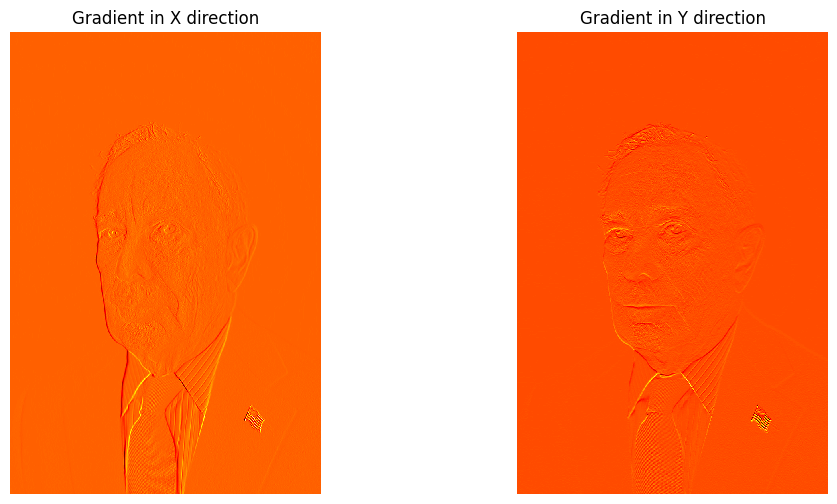

In [85]:
# put the ball there and let phyics move the ball

# Calculate the gradient of the squeezed tensor image
gradient_y, gradient_x = torch.gradient(squeezed_tensor_img)
# This gradietn assumes squeezed_tensor_image is some f: R^2 -> R

SCALE_FACTOR = 1
gradient_x *= SCALE_FACTOR
gradient_y *= SCALE_FACTOR

# Display the gradients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(gradient_x.numpy(), cmap='hot', interpolation='nearest')
ax1.set_title('Gradient in X direction')
ax1.axis('off')

ax2.imshow(gradient_y.numpy(), cmap='hot', interpolation='nearest')
ax2.set_title('Gradient in Y direction')
ax2.axis('off')

plt.show()

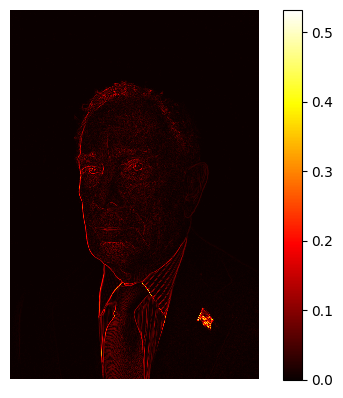

In [86]:
mag_grad = torch.sqrt(gradient_x ** 2 + gradient_y ** 2)
plt.imshow(mag_grad.numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.axis('off')  # Hide the axis
plt.show()

In [84]:
# Get the gradient at the ball position
ball_gradient_x = gradient_x[ball_position]
ball_gradient_y = gradient_y[ball_position]

print(f"Gradient at ball position (x): {ball_gradient_x}")
print(f"Gradient at ball position (y): {ball_gradient_y}")

Gradient at ball position (x): -1.960754332230863e-07
Gradient at ball position (y): -7.843136700103059e-07


assuming our image is some function f: R^2 -> R, then the gradient is simpley, df/dx and df/dy; if our units are 1 meter = 1 pixel, and 1 second = 1 frame; then df/dx = 0.00197 m/m (gradient in radians)

todo: this can be converted to theta by doing arcsing(radians)


- Add constant for energy of system
- Add gradient descent with momentum (exponential weighted average of velocity)

In [80]:
# Energy constant = KE + mgh

# CONSTANTS
max_energy_system = 5 # Max energy in the system
momentum_term = 0.9 # Momentum: exponential weighted average (how much we weight the most recent term)
step_size = 0.001 # step size

In [81]:
import math

def scale_vec(vector, mag):
    magnitue = torch.norm(vector)
    unit_vector = vector / magnitue
    return unit_vector * mag

def scale_to_system(vector, height):
    # max_energy_system = (1/22 + m * g * h
    # Assume m = 1
    """
    k = 0.5 * v ** 2 + g * h
    torch.sqrt((k - g * h) * 2) = v
    """
    g = 9.81
    new_mag = math.sqrt((max_energy_system - g * height) * 2)
    return scale_vec(vector, new_mag)